In [6]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import math
import pandas as pd
from datetime import datetime, timedelta, date, time
from shapely import Polygon
import contextily as cx
import h3
import seaborn as sns

In [3]:
df = vaex.open("data/trips/trips_prepared.hdf5")

In [4]:
df.info()

column,type,unit,description,expression
Taxi ID_encoded,int64,,,
Company,str,,,
Company_encoded,int64,,,
ts_start,datetime64[us],,,
ts_end,datetime64[us],,,
start_day,datetime64[us],,,
start_weekday,int32,,,
start_month,int32,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,


In [ ]:
df_weekday = df[df.start_weekday.isin([0, 1, 2, 3, 4])]
df_weekend = df[df.start_weekday.isin([5, 6])]

In [ ]:
# Calculate the average trips per hour for weekdays and weekends
average_trips_weekday = df_weekday.groupby(df_weekday.start_1_hour).agg({'Trip Total': 'mean'})['Trip Total'].values
average_trips_weekend = df_weekend.groupby(df_weekend.start_1_hour).agg({'Trip Total': 'mean'})['Trip Total'].values


In [ ]:
angles = np.linspace(0, 2 * np.pi, num=24, endpoint=False)

#vaex to numpy array
average_trips_weekday = average_trips_weekday
average_trips_weekend = average_trips_weekend


In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, polar=True)

#shifted_angles = np.roll(angles, -6)

# Plot average trips for weekdays in blue
ax.bar(angles, average_trips_weekday, width=0.5, align='edge', label='Weekday', color='blue', alpha=0.5)


# Plot average trips for weekends in red
ax.bar(angles, average_trips_weekend, width=0.5, align='edge', label='Weekend', color='red', alpha=0.5)

ax.set_xticks(angles)
ax.set_xticklabels(['6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm',
                    '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm',
                    '10pm', '11pm', '12am', '1am', '2am', '3am', '4am', '5am'])

ax.legend()
plt.show()


In [ ]:
#print(angles.shape)
#print(average_trips_weekday.shape)
#print(average_trips_weekend.shape)
import pandas as pd
df_pandas = df.to_pandas_df()

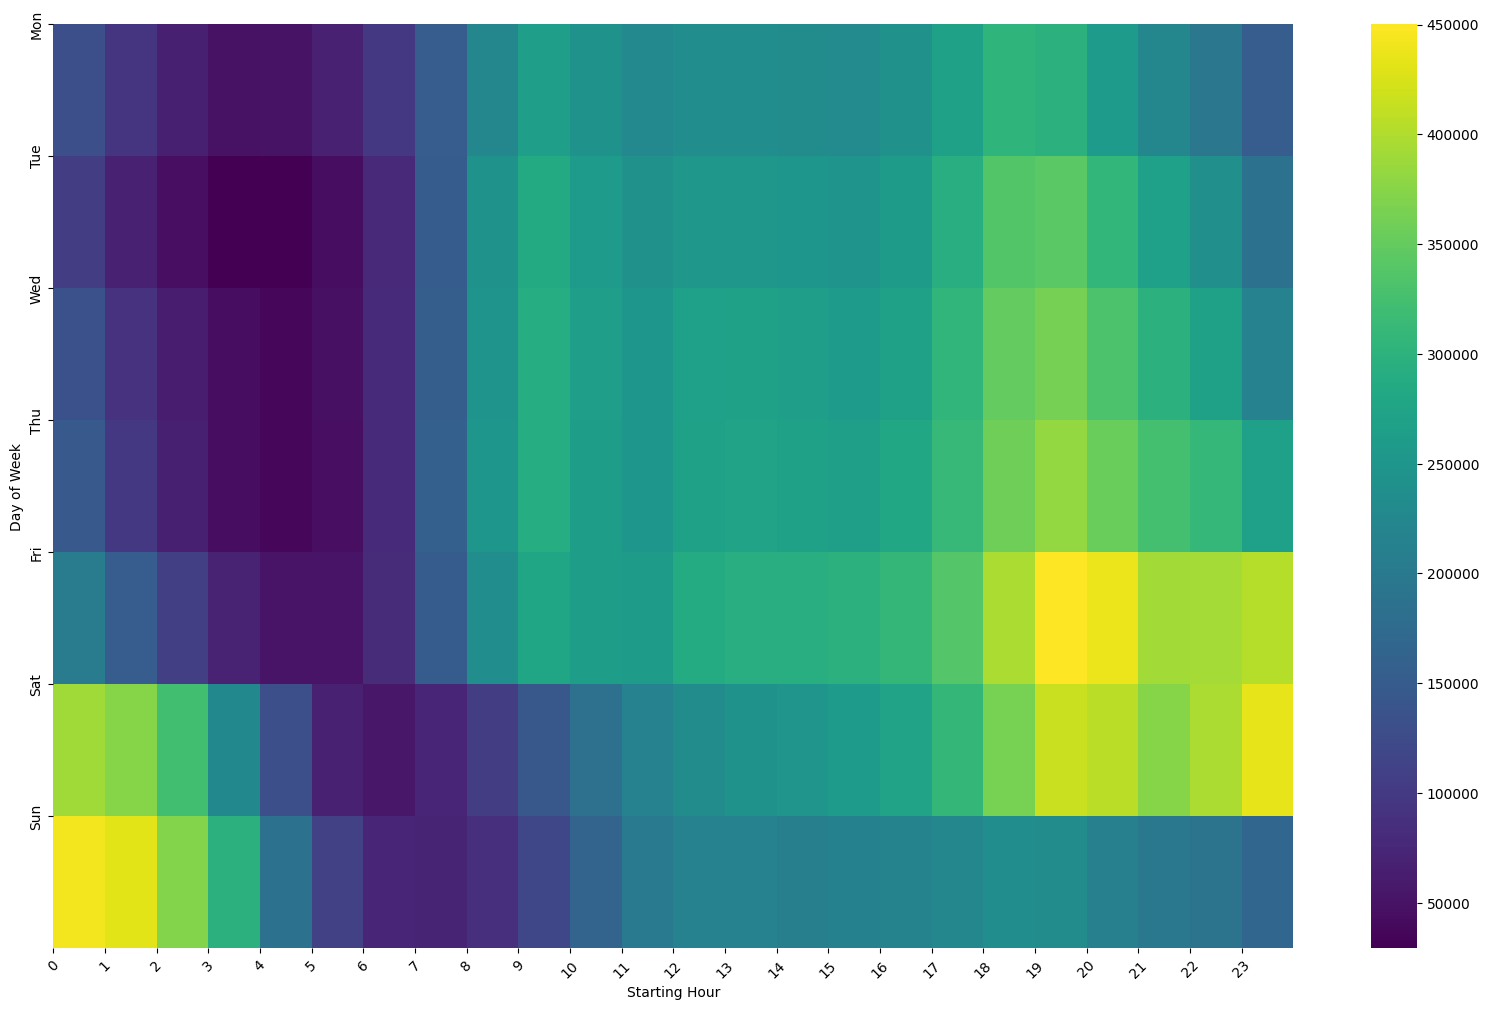

In [7]:
extract_1 = ['start_weekday', 'start_1_hour']
heatmap_df = df[extract_1]
pd_heatmap = heatmap_df.to_pandas_df()

# Calculate the count of trips for each combination of start_weekday and start_1_hour
heatmap_data = pd_heatmap.groupby(['start_weekday', 'start_1_hour']).size().unstack()

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(20, 12))

# Create the heatmap using seaborn 
sns.heatmap(heatmap_data, cmap='viridis', ax=ax)

# Set the labels for the x and y axes
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Day of Week')

# Set the tick locations and labels for the x and y axes
ax.set_xticks(np.arange(24))
ax.set_xticklabels(np.arange(24))
ax.set_yticks(np.arange(7))
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()


In [ ]:
# Calculate average trip distance
average_distance = df['Trip Miles'].mean().item()

# Calculate minimum trip distance
min_distance = df['Trip Miles'].min().item()

# Calculate maximum trip distance
max_distance = df['Trip Miles'].max().item()

print("Average Trip Distance:", average_distance)
print("Minimum Trip Distance:", min_distance)
print("Maximum Trip Distance:", max_distance)

# Calculate average trip duration
average_duration = df['Trip Seconds'].mean().item()

# Calculate minimum trip duration
min_duration = df['Trip Seconds'].min().item()

# Calculate maximum trip duration
max_duration = df['Trip Seconds'].max().item()

print("Average Trip Duration:", average_duration, "seconds")
print("Minimum Trip Duration:", min_duration, "seconds")
print("Maximum Trip Duration:", max_duration, "seconds")


In [ ]:
extract_plt = ['ts_start', 'start_weekday', 'start_month']

light_df_plt = df[extract_plt]

light_df_pd = light_df_plt.to_pandas_df()

grouped_by_month = light_df_pd.groupby('start_month').size()

# Create a bar plot
plt.figure(figsize=(10, 6))
grouped_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides for Each Starting Month')
plt.xticks(rotation=0)
plt.show()

grouped_by_month = light_df_pd.groupby('start_month')['ts_start'].agg(count='count')

# Print the count of rides and average trips per month
print("Count of Rides per Month:")
print(grouped_by_month['count'])

rides_sum_per_month = light_df_pd.groupby('start_month')['ts_start'].count()

# Calculate the total sum of rides across all months
total_rides_sum = rides_sum_per_month.sum()

# Print the total sum of rides
print("Total Sum of Rides:", total_rides_sum)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table to calculate the average trip duration
pivot_table = df_pandas.pivot_table(values='Trip Seconds', index='start_weekday', columns='start_1_hour', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f', cbar=True)
plt.title('Average Trip Duration by Start Hour and Weekday')
plt.xlabel('Start Hour')
plt.ylabel('Weekday')
plt.show()


## Spatial Analysis

### Import of Spatial and Weather Data

In [52]:
#Hexagons
trips_df_1h_r7 = vaex.open('data/trips/trips_grouped_1h_r7.hdf5')
trips_df_1h_r8 = vaex.open('data/trips/trips_grouped_1h_r8.hdf5')
trips_df_1h_r9 = vaex.open('data/trips/trips_grouped_1h_r9.hdf5')

trips_df_4h_r7 = vaex.open('data/trips/trips_grouped_4h_r7.hdf5')
trips_df_4h_r8 = vaex.open('data/trips/trips_grouped_4h_r8.hdf5')
trips_df_4h_r9 = vaex.open('data/trips/trips_grouped_4h_r9.hdf5')

trips_df_6h_r7 = vaex.open('data/trips/trips_grouped_6h_r7.hdf5')
trips_df_6h_r8 = vaex.open('data/trips/trips_grouped_6h_r8.hdf5')
trips_df_6h_r9 = vaex.open('data/trips/trips_grouped_6h_r9.hdf5')


#Census Tract and Community Area data
trips_df_1h_census = vaex.open('data/trips/trips_grouped_1h_census.hdf5')
trips_df_1h_carea = vaex.open('data/trips/trips_grouped_1h_comArea.hdf5')

trips_df_4h_census = vaex.open('data/trips/trips_grouped_4h_census.hdf5')
trips_df_4h_carea = vaex.open('data/trips/trips_grouped_4h_comArea.hdf5')

trips_df_6h_census = vaex.open('data/trips/trips_grouped_6h_census.hdf5')
trips_df_6h_carea = vaex.open('data/trips/trips_grouped_6h_comArea.hdf5')

df_tracts = gpd.read_file('data/raw/census_tract_geometry.geojson')
df_commarea = gpd.read_file('data/raw/community_area_geometry.geojson')

#Weather
weather_df_1h = pd.read_pickle('data/weather_data_hourly_1.pickle')
weather_df_4h = pd.read_pickle('data/weather_data_hourly_4.pickle')
weather_df_6h = pd.read_pickle('data/weather_data_hourly_6.pickle')

### Function Definition: Groupings and Maps

#### Hexagons

In [53]:
#Method to convert the hexagons to polygons using H3
def convert_hex_to_polygon(hex):
        polygon = None
        if hex:
               polygon = Polygon(h3.h3_to_geo_boundary(hex, geo_json=True))         
        return polygon

In [54]:
#A function to aggregate the trips for census tract and community area pickup and dropoff to create a geodataframe for visual representation
def create_hex_geodataframe(df, geometry):

    gdf = df.drop_duplicates()

    #Create the geodataframe and specify the geometry column for visual representation
    gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs="EPSG:4326")

    return gdf

In [55]:
def process_dataframes(df, hour, resolution, weather_df):
    trip_attributes = [
        'ts_start_{}_hour'.format(hour),
        'start_month',
        'start_weekday',
        'start_{}_hour'.format(hour),
        'pickup_hex_{}'.format(resolution),
        'demand',
        'Trip Seconds',
        'Trip Miles',
        'Fare',
        'Trip Total'
    ]
    
    df = df[trip_attributes].to_pandas_df()
    df_w = df.merge(weather_df, left_on = 'ts_start_{}_hour'.format(hour), right_on = 'datetime', how = 'left')
    df_w = df_w[(df_w['pickup_hex_{}'.format(resolution)].notna()) & (df_w['pickup_hex_{}'.format(resolution)] != 'None')]
    df_w['geometry'] = df_w['pickup_hex_{}'.format(resolution)].apply(convert_hex_to_polygon)


    gdf = create_hex_geodataframe(df_w, 'geometry')

    return gdf

In [56]:
#Prepare data for 1 hourly and resolutions 7 - 9
trips_gdf_1h_r7_w = process_dataframes(trips_df_1h_r7, 1, 7, weather_df_1h)
trips_gdf_1h_r8_w = process_dataframes(trips_df_1h_r8, 1, 8, weather_df_1h)
trips_gdf_1h_r9_w = process_dataframes(trips_df_1h_r9, 1, 9, weather_df_1h)

In [ ]:
#Prepare data for 4 hourly and resolutions 7 - 9
trips_gdf_4h_r7_w = process_dataframes(trips_df_4h_r7, 4, 7, weather_df_4h)
trips_gdf_4h_r8_w = process_dataframes(trips_df_4h_r8, 4, 8, weather_df_4h)
trips_gdf_4h_r9_w = process_dataframes(trips_df_4h_r9, 4, 9, weather_df_4h)

In [ ]:
#Prepare data for 6 hourly and resolutions 7 - 9
trips_gdf_6h_r7_w = process_dataframes(trips_df_6h_r7, 6, 7, weather_df_6h)
trips_gdf_6h_r8_w = process_dataframes(trips_df_6h_r8, 6, 8, weather_df_6h)
trips_gdf_6h_r9_w = process_dataframes(trips_df_6h_r9, 6, 9, weather_df_6h)

In [81]:
def trip_vis(gdf, groupby_col, agg_col, vis_col, text):
    gdf_agg = gdf.groupby(groupby_col).agg(agg_col, axis=1)#.rename(rename_col, axis=1)

    #map = plotRidesHexagon(gdf_agg, vis_col, text)

    return gdf_agg

#### Census Tract and Community Area

In [75]:
df_ct_ca = df.fillna(value= 0, column_names=['Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area'])
df_ct_ca['Pickup Census Tract'] = df_ct_ca['Pickup Census Tract'].astype('int64')
df_ct_ca['Dropoff Census Tract'] = df_ct_ca['Dropoff Census Tract'].astype('int64')
df_ct_ca['Pickup Community Area'] = df_ct_ca['Pickup Community Area'].astype('int64')
df_ct_ca['Dropoff Community Area'] = df_ct_ca['Dropoff Community Area'].astype('int64')

In [76]:
#A function to aggregate the trips for census tract and community area pickup and dropoff to create a geodataframe for visual representation
def create_geodataframe(column_groupby, array_drop_columns, column_join, geometry, merge_df):

    #Groupby spatial unit and count-aggregate for the trips started. Create a pandas-dataframe based on that
    gdf = df_ct_ca.groupby(by= column_groupby, progress=True).agg({ 'ts_start':'count' }).to_pandas_df()

    #Making sure no NaN or "None" values are present in the dataframe
    gdf = gdf[(gdf[column_groupby].notna()) & (gdf[column_groupby] != "None")]

    #Merge the taxi dataframe with the external dataframe containing the geometry information based on the given identifier column
    gdf = pd.merge(gdf, merge_df, left_on = column_groupby, right_on = column_join)

    #Drop non-essential columns
    gdf.drop(array_drop_columns, axis = 1, inplace = True)

    gdf = gdf.drop_duplicates()

    #Create the geodataframe and specify the geometry column for visual representation
    gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs="EPSG:4326")

    return gdf

In [77]:
#Create the four different dataframes 
df_census_pickup = create_geodataframe('Pickup Census Tract', ['geoid10'],'geoid10', 'geometry', df_tracts)
df_census_dropoff = create_geodataframe('Dropoff Census Tract', ['geoid10'], 'geoid10', 'geometry', df_tracts)
df_carea_pickup = create_geodataframe('Pickup Community Area', ['commarea'], 'commarea', 'geometry', df_commarea)
df_carea_dropoff = create_geodataframe('Dropoff Community Area', ['commarea'], 'commarea', 'geometry', df_commarea)

groupby [########################################] 100.00% elapsed time  :     1.18s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     1.08s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     1.24s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.80s =  0.0m =  0.0h
 

In [78]:
df_census_pickup.head()

,Pickup Census Tract,ts_start,geometry
0,17031832600,120893,"MULTIPOLYGON (((-87.65651 41.91079, -87.65682 ..."
1,17031081202,231225,"MULTIPOLYGON (((-87.62180 41.90410, -87.62097 ..."
2,17031020302,102,"MULTIPOLYGON (((-87.69018 42.00956, -87.69018 ..."
3,17031760802,8,"MULTIPOLYGON (((-87.85846 41.95793, -87.85833 ..."
4,17031560400,26,"MULTIPOLYGON (((-87.73990 41.80036, -87.74027 ..."


In [94]:
#Function to visualize the distribution of taxi trips in the different spatial units
def plotRidesHexagon(gdf, column, text):
    # Preparations for choropleth plotting
    #gdf.index.name = None
    gdf = gdf.reset_index()
    gjson = gdf.to_json()

    # Create a color map
    colormap = 'BuPu'

    # Calculate the color scale range based on the data
    min_value = gdf[column].min()
    max_value = gdf[column].max()

    # Plotting with Folium
    m = folium.Map(location=[41.88065, -87.62642], zoom_start=10)

    # Configure the choropleth layer
    folium.Choropleth(
        geo_data=gjson,
        name="choropleth",
        data=gdf,
        columns=["index", column],
        key_on='feature.properties.index',
        fill_opacity=0.7,
        line_opacity=0.2,
        fill_color=colormap,
        legend_name=text,
        line_color='black',
        highlight=True,  # Add interactivity for mouseover effect
        smooth_factor=1  # Improve the smoothness of polygon edges
    ).add_to(m)

    # Add tooltips to the polygons
    style_function = lambda x: {'fillColor': colormap(x['properties'][column]), 'color': 'blue', 'fillOpacity': 0.1, 'weight': 0.2}
    highlight_function = lambda x: {'fillColor': 'white', 'color': 'grey', 'fillOpacity': 0.3, 'weight': 0.1}

    #style_function = lambda x: {'fillColor': colormap, 'color': 'blue', 'fillOpacity': 0.1, 'weight': 0.2}
    #highlight_function = lambda x: {'fillColor': 'white', 'color': 'grey', 'fillOpacity': 0.3, 'weight': 0.1}
    tooltip = folium.features.GeoJsonTooltip(fields=[column], aliases=[text], localize=True)
    folium.GeoJson(
        gjson,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=tooltip
    ).add_to(m)


    return m

### Analysis Hexagons

#### Finding optimal resolution

In [110]:
df = trip_vis(trips_gdf_1h_r7_w, 'geometry', {'demand': 'sum'}, 'demand', 'test')

In [112]:
df = df.reset_index()
df

,index,geometry,demand
0,0,"POLYGON ((41.63881 41.67712, 41.63556 41.66475...",331
1,1,"POLYGON ((41.65794 41.69288, 41.65469 41.68051...",609
2,2,"POLYGON ((41.66732 41.67152, 41.66407 41.65915...",1
3,3,"POLYGON ((41.67708 41.70862, 41.67382 41.69626...",2032
4,4,"POLYGON ((41.69622 41.72436, 41.69296 41.71200...",4748
5,5,"POLYGON ((41.71536 41.74010, 41.71210 41.72773...",1693
6,6,"POLYGON ((41.68645 41.68727, 41.68319 41.67490...",3
7,7,"POLYGON ((41.73451 41.75582, 41.73124 41.74346...",14155
8,8,"POLYGON ((41.77281 41.78725, 41.76955 41.77490...",409258
9,9,"POLYGON ((41.75366 41.77154, 41.75039 41.75918...",19779


In [113]:
plotRidesHexagon(df, 'demand', 'text')

ValueError: cannot insert geometry, already exists

In [61]:
trips_gdf_1h_r7_w.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 173125 entries, 0 to 190642
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   ts_start_1_hour  173125 non-null  object  
 1   start_month      173125 non-null  int64   
 2   start_weekday    173125 non-null  int64   
 3   start_1_hour     173125 non-null  int64   
 4   pickup_hex_7     173125 non-null  object  
 5   demand           173125 non-null  int64   
 6   Trip Seconds     173115 non-null  float64 
 7   Trip Miles       173125 non-null  float64 
 8   Fare             173125 non-null  float64 
 9   Trip Total       173125 non-null  float64 
 10  Temperature      173125 non-null  float64 
 11  Humidity         173125 non-null  float64 
 12  Wind Speed       173125 non-null  float64 
 13  Precip.          173125 non-null  float64 
 14  cloud            173125 non-null  float64 
 15  rain             173125 non-null  float64 
 16  Fair             

In [ ]:
plotRidesHexagon(trips_gdf_1h_r7_w,  'demand', 'Hourly demand with hex_resolution 7')

#### Overall Demand

In [ ]:
plotRidesHexagon(gdf, column, text)

#### Demand by Time of Day

#### Demand by Day of the Week

#### Demand by Season

#### Weather dependent Demand

##### Temperature

##### Weather condition (Rain, Sun)

#### Trip length

### Analysis Census Tract and Community Areas

#### Overall Demand

In [ ]:
plotRidesHexagon(df_census_pickup, "ts_start", "Rides with pickup location in Census Tract")

The map shows that most taxi trips are started in census tracts close to the main city center as well as the O'Hare International Airport. Due to the high number of trips in these tracts, the colouring of the others moves into the background. Based on this insight we´ll use the natural logarithm to get a better overview of the distribution

In [ ]:
df_census_pickup["logCount"] = np.log(df_census_pickup['ts_start'])
plotRidesHexagon(df_census_pickup, "logCount", "Natural Logarithm of rides with pickup location in Census Tract")

The map gives an overview over trips started in the census tracts.The city center still contains the tracts with the most trips started, but in comparison to the map shown before, additional tracts can be labelled as important. Most of them are close to the waterfront and above the city center, with the exception of the second airport (Chicago Midway International Airport) also showing a high number of started trips

In [ ]:
plotRidesHexagon(df_census_dropoff, "ts_start", "Rides with dropoff location in Census Tract")

The number of trips ending in census tracts can be viewed as mirror of the starting trips in census tracts with slight differences. One additional tract below the city center shows increased dropoff numbers. Otherwise the map again is not very meaningful which is why the logarithm is applied in the next step

In [ ]:
df_census_dropoff["logCount"] = np.log(df_census_dropoff['ts_start'])
plotRidesHexagon(df_census_dropoff, "logCount", "Natural Logarithm of rides with dropoff location in Census Tract")

Compared to the tract pickup map, there are again only minimal differences in tracts that contain a higher number of dropoff numbers. 

In [ ]:
plotRidesHexagon(df_carea_pickup, "ts_start", "Rides with pickup location in Community Area")

The community areas should now reflect what could already been seen from the census tract map. Pickup numbers are highly concentrated on the city center of chicago.

In [ ]:
df_carea_pickup["logCount"] = np.log(df_carea_pickup['ts_start'])
plotRidesHexagon(df_carea_pickup, "logCount", "Natural Logarithm of rides with pickup location in Community Area")

The logarithm of the pickup numbers gives a more meaningful visualization of the pickup data in the community areas. This map just validates what has already been shown by the census tracts. High numbers in the city center and up the waterfront to the north as well as close to the two airports

In [ ]:
plotRidesHexagon(df_carea_dropoff, "ts_start", "Rides with dropoff location in Community Area")

Compared to the pickup data in the community areas, the dropoff data is again very much the same with only minimal differences in the areas close to the city center

In [ ]:
df_carea_dropoff["logCount"] = np.log(df_carea_dropoff['ts_start'])
plotRidesHexagon(df_carea_dropoff, "logCount", "Natural Logarithm of rides with dropoff location in Community Area")

The same conclusion as above can be reached for the dropoff data after applying the logarithm. It is very much the same to the pickup data for the community areas

#### Demand by Time of Day

#### Demand by Day of the Week

#### Demand by Season

In [ ]:
#Assigning a season to each entry
def map_month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'


df['season'] = df.apply(map_month_to_season, arguments=[df['start_month']])

# Plot the distribution of seasons
df_grouped = df.groupby('season', agg={'count': vaex.agg.count()})
df_grouped = df_grouped.sort(by='count', ascending=False)

# Convert vaex DataFrame to a pandas DataFrame for plotting with matplotlib
df_pandas = df_grouped.to_pandas_df()

# Create a bar plot using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(df_pandas['season'], df_pandas['count'])
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Distribution of Seasons')
plt.show()

#### Weather dependent Demand

In [ ]:
df_weather = pd.read_pickle("data/weather_data_hourly_1.pickle")
df_weather.info()

In [ ]:
df.head()

In [ ]:
extract = ['ts_start', 'start_weekday', 'start_month', 'ts_start_1_hour','start_1_hour', 'Trip Seconds']

light_df = df[extract]
light_df.info()

In [ ]:
light_pd = light_df.to_pandas_df()

merged_pandas_df = light_pd.join(df_weather, on='ts_start_1_hour', how='left')

In [ ]:
merged_pandas_df.info()

##### Temperature

In [ ]:
# Define temperature bins and labels in 5-degree Celsius intervals up to 40 degrees
temperature_bins = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
temperature_labels = ['-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '10 to 15', '15 to 20',
                      '20 to 25', '25 to 30', '30 to 35', '35 to 40']

# Create temperature bins and group by them, then count the number of rides within each temperature range
merged_pandas_df['Temperature Range'] = pd.cut(merged_pandas_df['Temperature'], bins=temperature_bins, labels=temperature_labels)
grouped_df = merged_pandas_df.groupby('Temperature Range').size()

# Create a bar plot
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar')
plt.xlabel('Temperature Range in Celsius')
plt.ylabel('Number of Rides')
plt.title('Number of Rides for Different Temperature Ranges')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# import seaborn as sns
# # Create temperature bins and group by them, then count the number of rides within each temperature range
# temperature_bins = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
# temperature_labels = ['-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '10 to 15', '15 to 20',
#                       '20 to 25', '25 to 30', '30 to 35', '35 to 40']
# merged_pandas_df['Temperature Range'] = pd.cut(merged_pandas_df['Temperature'], bins=temperature_bins, labels=temperature_labels)
# pivot_table = merged_pandas_df.pivot_table(index='Temperature Range', columns='start_month', values='ts_start', aggfunc='count')

# plt.figure(figsize=(10, 6))
# sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d')
# plt.xlabel('Month')
# plt.ylabel('Temperature Range')
# plt.title('Number of Rides Heatmap')

# # Format y-axis tick labels to display full numbers
plt.show()

##### Weather condition (Rain, Sun)

In [ ]:
# Calculate total number of trips for different weather conditions
total_trips_fair = merged_pandas_df.loc[merged_pandas_df['Fair'] > 0].shape[0]
total_trips_bad = merged_pandas_df.loc[merged_pandas_df['Fair'] == 0].shape[0]
total_trips_no_rain = merged_pandas_df.loc[merged_pandas_df['rain'] == 0].shape[0]
total_trips_with_rain = merged_pandas_df.loc[merged_pandas_df['rain'] > 0].shape[0]
total_trips_snow = merged_pandas_df.loc[merged_pandas_df['Snow'] > 0].shape[0]
total_trips_cloud = merged_pandas_df.loc[merged_pandas_df['cloud'] > 0].shape[0]
total_trips_fog = merged_pandas_df.loc[merged_pandas_df['Fog'] > 0].shape[0]
total_trips_tstorm = merged_pandas_df.loc[merged_pandas_df['T-Storm'] > 0].shape[0]
total_trips_thunder = merged_pandas_df.loc[merged_pandas_df['Thunder'] > 0].shape[0]

# Weather conditions and corresponding total trip counts
weather_conditions = ['Good Weather', 'Bad Weather', 'No Rain', 'With Rain', 'Snow', 'Cloud', 'Fog', 'T-Storm', 'Thunder']

total_trip_counts = [
    total_trips_fair, total_trips_bad, total_trips_no_rain, total_trips_with_rain,
    total_trips_snow, total_trips_cloud, total_trips_fog,
    total_trips_tstorm, total_trips_thunder
]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(weather_conditions, total_trip_counts)
plt.xlabel('Weather Conditions')
plt.ylabel('Total Trip Count')
plt.title('Total Trip Count for Different Weather Conditions')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text labels on top of the bars
for bar, count in zip(bars, total_trip_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
#calculating averages
avg_duration_fair = merged_pandas_df.loc[merged_pandas_df['Fair'] > 0, 'Trip Seconds'].mean()
avg_duration_bad = merged_pandas_df.loc[merged_pandas_df['Fair'] == 0, 'Trip Seconds'].mean()
avg_duration_no_rain = merged_pandas_df.loc[merged_pandas_df['rain'] == 0, 'Trip Seconds'].mean()
avg_duration_with_rain = merged_pandas_df.loc[merged_pandas_df['rain'] > 0, 'Trip Seconds'].mean()
avg_duration_snow = merged_pandas_df.loc[merged_pandas_df['Snow'] > 0, 'Trip Seconds'].mean()
avg_duration_cloud = merged_pandas_df.loc[merged_pandas_df['cloud'] > 0, 'Trip Seconds'].mean()
avg_duration_fog = merged_pandas_df.loc[merged_pandas_df['Fog'] > 0, 'Trip Seconds'].mean()
avg_duration_tstorm = merged_pandas_df.loc[merged_pandas_df['T-Storm'] > 0, 'Trip Seconds'].mean()
avg_duration_thunder = merged_pandas_df.loc[merged_pandas_df['Thunder'] > 0, 'Trip Seconds'].mean()


print("Average trip duration on days with good weather: ", avg_duration_fair)
print("Average trip duration on days with bad weather: ", avg_duration_bad)
print("Average trip duration on days without rain:", avg_duration_no_rain)
print("Average trip duration on days with rain:", avg_duration_with_rain)
print("Average trip duration on days with snow: ", avg_duration_snow)
print("Average trip duration on days with clouds: ", avg_duration_cloud)
print("Average trip duration on days with fog: ", avg_duration_fog)
print("Average trip duration on days with Thunder Storms: ", avg_duration_tstorm)
print("Average trip duration on days with thunder: ", avg_duration_thunder)

weather_conditions = ['Good Weather', 'Bad Weather', 'No Rain', 'With Rain', 'Snow', 'Cloud', 'Fog', 'T-Storm', 'Thunder']

avg_durations = [
    round(avg_duration_fair, 0), round(avg_duration_bad, 0), round(avg_duration_no_rain, 0),
    round(avg_duration_with_rain, 0), round(avg_duration_snow, 0), round(avg_duration_cloud, 0),
    round(avg_duration_fog, 0), round(avg_duration_tstorm, 0), round(avg_duration_thunder, 0)
]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(weather_conditions, avg_durations)
plt.xlabel('Weather Conditions')
plt.ylabel('Average Trip Duration in Seconds')
plt.title('Average Trip Duration for Different Weather Conditions')
plt.xticks(rotation=45)
plt.tight_layout()

for bar, count in zip(bars, avg_durations):
    plt.text(bar.get_x() + bar.get_width() / 2, count, f'{count:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()